<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_Pre_%26_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

Riferimento: https://stackoverflow.com/questions/30483246/how-to-check-if-a-python-module-has-been-imported

In [3]:
catboost = 'catboost'
if catboost not in sys.modules:
  !pip install catboost -v

Created temporary directory: /tmp/pip-ephem-wheel-cache-7a9vh5t6
Created temporary directory: /tmp/pip-req-tracker-n2x4tvk7
Created requirements tracker '/tmp/pip-req-tracker-n2x4tvk7'
Created temporary directory: /tmp/pip-install-l_aoqba1
Cleaning up...
Removed build tracker '/tmp/pip-req-tracker-n2x4tvk7'


# Feature scaling

Implemento il min max scaling delle features. 

Riferimento: https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475

In [4]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv'):
  correlation_data = min_max_scaling(correlation_data)
  correlation_data.to_csv(r'./corr_data.csv')

if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  correlation_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv')

Riferimento `save_model` e `load_model`: https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn

Riferimento confusion matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


# Dataset merging

Funzione che ritorna la lista delle colonne significative. 

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # serve per ignorare i FutureWarning

Rimpiazzo i missing values in categorical data con unknown. 

Unisco i dataset numerici e categorici nel dataframe data. 

Riferimento fillna: https://jamesrledoux.com/code/imputation

In [6]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  col_to_drop = col_not_sign(categorical_data, cat_sign_col)
  categorical_data = categorical_data.drop(col_to_drop, axis=1)
  categorical_data = categorical_data.fillna('unknown')
  data = pd.merge(correlation_data, categorical_data, left_on='TransactionID', right_on='TransactionID', how='left')
  del correlation_data, categorical_data, numerical_data
  data.to_csv(r'./data.csv')

data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [7]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
time = data['TransactionDT'].values.reshape(-1,1)
data['TransactionDT'] = min_max_scaler.fit_transform(time)
data.drop(columns=['TransactionID'], inplace=True)

In [8]:
fraud = (data['isFraud'] == 1).sum()
safe = (data['isFraud'] == 0).sum()
ratio = np.ceil(safe/fraud)

### Load

In [9]:
load = False
if load:
  model = CatBoostClassifier()
  model.load_model('catboost')  
  # model.load_model('catboost_class_weights')

### Train validation test split


In [10]:
X_train, X_val, y_train, y_val = mf.split(data, test_size = 0.2)
del data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
def row_ids(X_train):
  selected_rows= []
  for i in range(X_train.shape[0]):
    selected_rows.append(X_train.iloc[i].name)
  return selected_rows

train_rows = row_ids(X_train)
# train_rows

In [11]:
file = open("/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/cat_sign_col.txt", "r")
cat_sign_col = file.read() # importo il file
cat_sign_col = cat_sign_col.split(" ") # le colonne sono separate dallo spazio
file.close() 
cat_sign_col.pop() # levo l'ultimo elemento che è vuoto

''

# Categorical Boost

Con 2000 iterazioni: AUC= 0.9, AP= 0.7

Con 4000 iterazioni: AUC= 0.92, AP= 0.73

Con class_weight: AUC = 0.91, AP = 0.68, F1 = 0.81, CM =  [[112057   1796]
 [  1459   2795]]

Non è stato fatto nè il one hot encoding nè l'easy ensemble.

Documentazione CatBoost: https://catboost.ai/docs/concepts/python-quickstart.html

Categorical features parameter: https://github.com/catboost/catboost/issues/934

gpu: https://catboost.ai/docs/features/training-on-gpu.html

Riferimento salvataggio del modello: https://stackoverflow.com/questions/51895761/how-to-correctly-load-pretrained-model-in-catboost-in-python

Riferimento class_weights: https://stackoverflow.com/questions/59746304/catboost-classifier-for-class-imbalance



In [12]:
from catboost import CatBoostClassifier, Pool
# model = CatBoostClassifier(iterations=4000, depth=10, learning_rate=1, class_weights = (1, ratio), task_type="GPU",
#                           cat_features = cat_sign_col, loss_function='Logloss', verbose=False)
# model = CatBoostClassifier(iterations=4000, depth=16, learning_rate=1, task_type="GPU",
#                           cat_features = cat_sign_col, loss_function='CrossEntropy', verbose=False)
model = CatBoostClassifier(iterations=3000, boosting_type='Plain', bootstrap_type='Bernoulli', 
                            subsample=0.5, border_count=32,
                            depth=10, learning_rate=1, task_type="GPU",
                            cat_features = cat_sign_col, loss_function='CrossEntropy', verbose=False)
model.fit(X_train, y_train)

In [13]:
save = True
if save:
  model.save_model('catboost_new')

# Performance evaluation

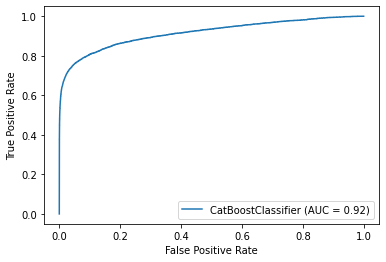

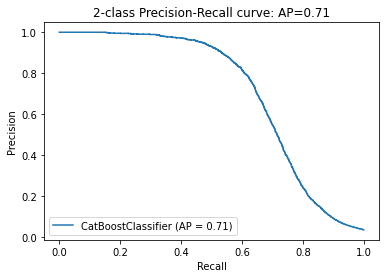

In [14]:
mf.performance(model, X_val, y_val)

[[113407    446]
 [  1789   2465]]


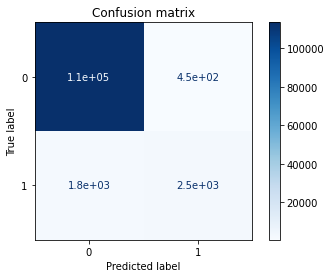

In [15]:
mf.conf_matrix(model, X_val, y_val)

In [16]:
mf.f1(model, X_val, y_val)

0.8391546274482169

## LIME


**LIME Local interpretable model-agnostic explanations**

1. LIME generates a new dataset consisting of: 
  * permuted samples, drawing from a normal distribution with mean and standard deviation taken from the feature (in case of tabular data);
  * the corresponding predictions of the black box model;
2. On this new dataset LIME then trains an interpretable model;
3. The model is weighted by the proximity of the sampled instances to the instance of interest.

The **recipe for training local surrogate models**:
1. Select your instance of interest for which you want to have an explanation of its black box prediction.
2. Perturb your dataset and get the black box predictions for these new points.
3. Weight the new samples according to their proximity to the instance of interest.
4. Train a weighted, interpretable model on the dataset with the variations.
5. Explain the prediction by interpreting the local model.

Tutorial LIME: https://blog.dominodatalab.com/shap-lime-python-libraries-part-2-using-shap-lime/

Documentazione LIME: https://lime-ml.readthedocs.io/en/latest/lime.html

In [ ]:
X_test.values[0]

In [44]:
model.predict_proba(X_test.values[0])[1]

0.0006449455157682411

In [45]:
if 'lime' not in sys.modules:
  !pip install lime -v

def lime(X_train, X_test, categorical_features, clf, n_features, j=0):
  import lime
  import lime.lime_tabular

  # setup dell'esxplainer
  explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                      class_names=['isFraud'],
                                                      categorical_features=categorical_features,
                                                      verbose=True, mode='classification')#,discretize_continuous = True, discretizer='decile')
  
  # explanation
  exp = explainer.explain_instance(X_test.values[j], clf.predict_proba[1], num_features=n_features)
  exp.show_in_notebook(show_table=True)
  return  

In [46]:
lime(X_train, X_test, cat_sign_col, model, 10)

TypeError: ignored